## Validate positional encodings, at least for the node classification tasks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor 
import torch
from torch_geometric.datasets import GNNBenchmarkDataset
import torch_geometric.transforms as trans
import pandas as pd
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering
from munkres import Munkres
from sklearn.metrics.cluster import contingency_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns

In [2]:
### Load CLUSTER dataset (both train, and test data)
clus_train = GNNBenchmarkDataset(root='./data', name="CLUSTER")
clus_test = GNNBenchmarkDataset(root='./data', name="CLUSTER", split="test")

In [3]:
pat_train = GNNBenchmarkDataset(root='./data', name="PATTERN")
pat_test = GNNBenchmarkDataset(root='./data', name="PATTERN", split="test")

In [4]:
### Print info on the test data
print(f"# classes = {clus_test.num_classes}")
print(f"length of dataset = {len(clus_test)}")
print(f"# features per node  = {clus_test.num_node_features}")

# classes = 6
length of dataset = 1000
# features per node  = 7


In [32]:
def generate_adjacency_from_graph(geo_data):
    dico = geo_data.to_dict()
    nodes = pd.DataFrame(np.array(dico['x']))
    edges = np.array(dico['edge_index']).T
    labels = np.array(dico['y'])

    # generate adjacency matrix
    adj = np.zeros((nodes.shape[0], nodes.shape[0]))
    deg = np.zeros((nodes.shape[0], nodes.shape[0]))
    for e in edges:
        adj[e[0], e[1]] = 1
        deg[e[0], e[0]] += 1
        deg[e[1], e[1]] += 1
    adj = sparse.csr_matrix(adj)
    deg = sparse.csr_matrix(deg)
    return nodes, adj, deg, labels

In [12]:
def leiden_clustering(nodes, adj, labels, resolution=1):
    adata = sc.AnnData(nodes)
    adata.obs["label"] = labels
    sc.tl.leiden(adata, resolution=resolution, adjacency=adj, random_state=42, directed=True)
    return adata

In [13]:
def hungarian_matching(pred, labels):
    m = Munkres()
    contmat = contingency_matrix(pred, labels)
    ind = dict(m.compute(contmat.max() - contmat))
    pred_adjusted = list(map(ind.get, pred))
    return pred_adjusted, accuracy_score(pred_adjusted, labels)

## Let's first plot the laplacian eigenvectors

In [34]:
sample = clus_test[0]
nodes, adj, deg, labels = generate_adjacency_from_graph(sample)
adj_ar = adj.toarray()
deg_ar = deg.toarray()

In [38]:
lap = (deg_ar - adj_ar)
for i in range(len(nodes)):
    lap[i,i] /= deg_ar[i,i]
lap

array([[ 1.,  0., -1., ...,  0.,  0.,  0.],
       [ 0.,  1., -1., ..., -1.,  0.,  0.],
       [-1., -1.,  1., ...,  0.,  0., -1.],
       ...,
       [ 0., -1.,  0., ...,  1., -1., -1.],
       [ 0.,  0.,  0., ..., -1.,  1., -1.],
       [ 0.,  0., -1., ..., -1., -1.,  1.]])

In [62]:
w, v = np.linalg.eig(lap)
v = v[np.argsort(w)]
v.shape, w.shape

((134, 134), (134,))

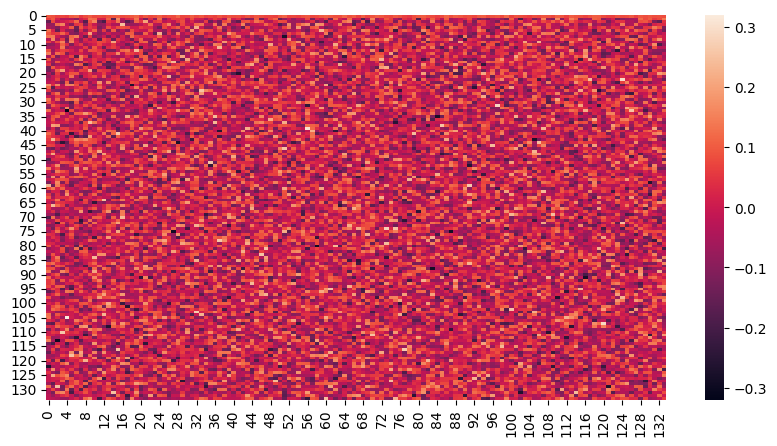

In [64]:
plt.figure(figsize=(10,5))
sns.heatmap(v.T)
plt.show()

Let's compare the performances of Spectral Clustering VS a random classifier
The goal is to say that information is contained in the Laplacian eigenvectors and that it can help cluster nodes together => defines a certain notion of order.

In [78]:
%%time
acc_list_clus = []
rand_list_clus = []
for i, sample in enumerate(clus_test):
    nodes, adj, deg, labels = generate_adjacency_from_graph(sample)
    spec = SpectralClustering(6, affinity='precomputed')
    spec.fit(adj)
    pred_adj, acc = hungarian_matching(spec.labels_, labels)
    rand_labels = np.random.randint(6, size=len(nodes))
    _, rand_acc = hungarian_matching(rand_labels, labels)
    acc_list_clus.append(acc)
    rand_list_clus.append(rand_acc)
    if i%100 == 0:
        print(f"Accuracy of {i}th graph = {acc}")

Accuracy of 0th graph = 0.7985074626865671
Accuracy of 100th graph = 0.5584415584415584
Accuracy of 200th graph = 0.5434782608695652
Accuracy of 300th graph = 0.7
Accuracy of 400th graph = 0.7142857142857143
Accuracy of 500th graph = 0.6018518518518519
Accuracy of 600th graph = 0.6534653465346535
Accuracy of 700th graph = 0.7094594594594594
Accuracy of 800th graph = 0.7053571428571429
Accuracy of 900th graph = 0.7022900763358778
CPU times: user 6min 11s, sys: 611 ms, total: 6min 12s
Wall time: 54.1 s


In [80]:
%%time
acc_list_pat = []
rand_list_pat = []
for i, sample in enumerate(pat_test):
    nodes, adj, deg, labels = generate_adjacency_from_graph(sample)
    spec = SpectralClustering(2, affinity='precomputed')
    spec.fit(adj)
    pred_adj, acc = hungarian_matching(spec.labels_, labels)
    rand_labels = np.random.randint(2, size=len(nodes))
    _, rand_acc = hungarian_matching(rand_labels, labels)
    acc_list_pat.append(acc)
    rand_list_pat.append(rand_acc)
    if i%100 == 0:
        print(f"Accuracy of {i}th graph = {acc}")

Accuracy of 0th graph = 0.5212765957446809
Accuracy of 100th graph = 0.5408163265306123
Accuracy of 200th graph = 0.5234375
Accuracy of 300th graph = 0.5789473684210527
Accuracy of 400th graph = 0.5
Accuracy of 500th graph = 0.5390070921985816
Accuracy of 600th graph = 0.5463917525773195
Accuracy of 700th graph = 0.56
Accuracy of 800th graph = 0.5181818181818182
Accuracy of 900th graph = 0.5487804878048781
Accuracy of 1000th graph = 0.5064935064935064
Accuracy of 1100th graph = 0.5338345864661654
Accuracy of 1200th graph = 0.5267857142857143
Accuracy of 1300th graph = 0.6020408163265306
Accuracy of 1400th graph = 0.5041322314049587
Accuracy of 1500th graph = 0.5371900826446281
Accuracy of 1600th graph = 0.5925925925925926
Accuracy of 1700th graph = 0.5333333333333333
Accuracy of 1800th graph = 0.5446428571428571
Accuracy of 1900th graph = 0.5147058823529411
CPU times: user 9min 13s, sys: 1.78 s, total: 9min 15s
Wall time: 1min 28s


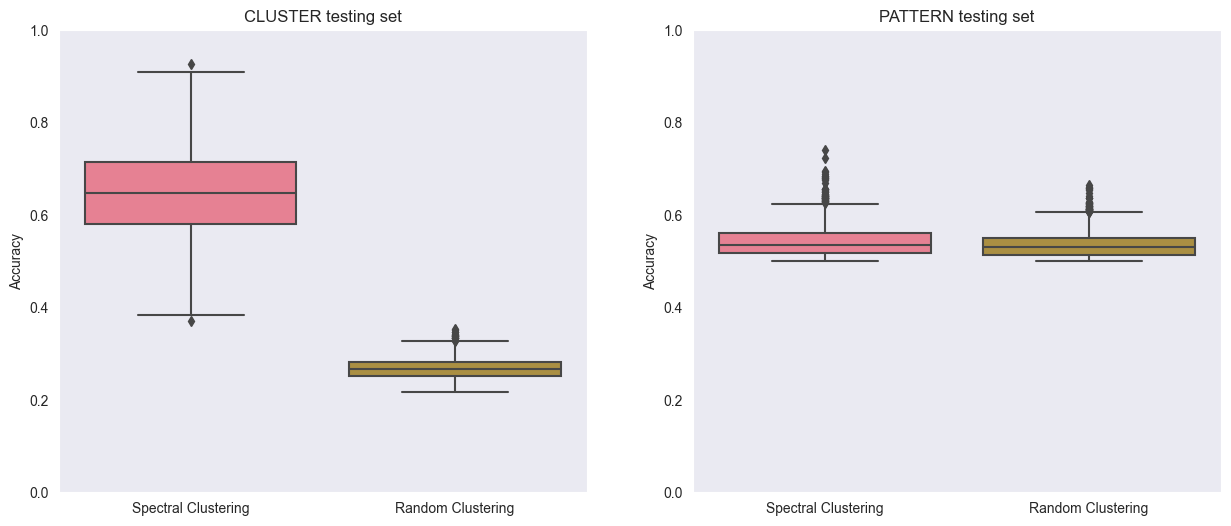

In [83]:
acc_df_pat = pd.DataFrame(np.array([acc_list_pat, rand_list_pat]).T, columns=['Spectral Clustering', 'Random Clustering'])
acc_df_clus = pd.DataFrame(np.array([acc_list_clus, rand_list_clus]).T, columns=['Spectral Clustering', 'Random Clustering'])

sns.set_style("dark")
sns.set_palette("husl")
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.boxplot(data=acc_df_clus)
plt.ylabel("Accuracy")
plt.ylim((0,1))
plt.title("CLUSTER testing set")

plt.subplot(1,2,2)
sns.boxplot(data=acc_df_pat)
plt.ylabel("Accuracy")
plt.ylim((0,1))
plt.title("PATTERN testing set")
plt.savefig("laplacian_eigenvectors.png")
plt.show()

## Let's try to see if simpler methods (non deep) can solve graph regression problems

In [5]:
from torch_geometric.datasets import ZINC
from grakel import Graph
from grakel.kernels import WeisfeilerLehman, VertexHistogram, ShortestPath, RandomWalk, NeighborhoodSubgraphPairwiseDistance
from sklearn.metrics import mean_absolute_error as mae
from sklearn.svm import SVR

In [6]:
z = ZINC('./data', subset=True)
z_test = ZINC('./data', subset=True, split='test')
len(z), z.num_node_features

(10000, 1)

In [7]:
def create_grakel_graph(g):
    edges = [tuple(edge) for edge in np.array(g['edge_index']).T]
    edges_attr = np.array(g['edge_attr'])
    node_labels = dict([(i, lab[0]) for i, lab in enumerate(np.array(g['x']))])
    edge_labels = dict([(i, lab) for i, lab in enumerate(edges_attr)])
    return Graph(edges, node_labels=node_labels, edge_labels=edge_labels)

In [8]:
%%time
graphs_train = []
graphs_test = []

for g in z:
    graphs_train.append(create_grakel_graph(g))

for g in z_test:
    graphs_test.append(create_grakel_graph(g))

CPU times: user 3.15 s, sys: 41.9 ms, total: 3.19 s
Wall time: 3.19 s


In [9]:
%%time
y_train = []
y_test = []
for g in z:
    y_train.append(float(g['y']))
for g in z_test:
    y_test.append(float(g['y']))

CPU times: user 232 ms, sys: 21.7 ms, total: 254 ms
Wall time: 220 ms


In [15]:
wl_kernel = WeisfeilerLehman(n_iter=5, normalize=True, base_graph_kernel=VertexHistogram)
k_train = wl_kernel.fit_transform(graphs_train)
k_test = wl_kernel.transform(graphs_test)

In [16]:
svr = SVR(kernel='precomputed')
svr.fit(k_train, y_train)

SVR(kernel='precomputed')

In [17]:
y_pred = svr.predict(k_test)
err = mae(y_pred, y_test)
err

0.4865719737017495

In [14]:
rw_kernel = RandomWalk(p=2)
k_train = rw_kernel.fit_transform(graphs_train)
k_test = rw_kernel.transform(graphs_test)

KeyboardInterrupt: 

In [ ]:
svr = SVR(kernel='precomputed')
svr.fit(k_train, y_train)
y_pred = svr.predict(k_test)
err = mae(y_pred, y_test)
err